In [36]:
import warnings

import pandas as pd
import numpy as np

#metrics
from sklearn.metrics import roc_curve, auc, confusion_matrix
#estimators
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
#cross selection
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt

In [37]:
warnings.filterwarnings(action="once")

In [38]:
df = pd.read_excel('Data/Data_2013-2022.xlsx')

In [39]:
def confusion(y_test, y_pred) : 
    mat = confusion_matrix(y_test, y_pred)
    mat = pd.DataFrame(mat)
    mat.columns = [f"pred_{i}" for i in mat.columns]
    mat.index = [f"test_{i}" for i in mat.index]
    return mat

In [46]:
def score(estimator) :
    tr_score = estimator.score(X_train, y_train).round(4)
    te_score = estimator.score(X_test, y_test).round(4)

    print(f"score train : {tr_score} score test : {te_score} ")

# 1. Data preparation

In [40]:
#Shuffle data
df = df.sample(frac=1).reset_index(drop=True)

In [41]:
df = df.drop(columns=["Race","Year"])

In [42]:
X = df.drop(columns="Breakaway win")
y = df["Breakaway win"]

In [43]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=42)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(505, 9) (505,) (57, 9) (57,)


# 2. Modelisation

## 2.1 Dummy classifier

In [44]:
estimator = DummyClassifier(strategy="most_frequent")
estimator.fit(X_train, y_train)
#cv_results = cross_validate(estimator, X_train, y_train, cv=3,return_estimator=True)

DummyClassifier(strategy='most_frequent')

In [10]:
cv_results['test_score']

array([0.62130178, 0.61904762, 0.61904762])

In [11]:
cv_results['test_score'].mean()

0.619799004414389

In [12]:
test_score = []
for i in range(len(cv_results['estimator'])):
  test_score.append(cv_results['estimator'][i].score(X_test, y_test))

In [13]:
sum(test_score) / len(test_score)

0.6491228070175439

In [47]:
score(estimator)

score train : 0.6198 score test : 0.6491 


In [48]:
y_pred = estimator.predict(X_test)

In [49]:
confusion(y_test, y_pred)

,pred_0,pred_1
test_0,37,0
test_1,20,0


In [50]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.5

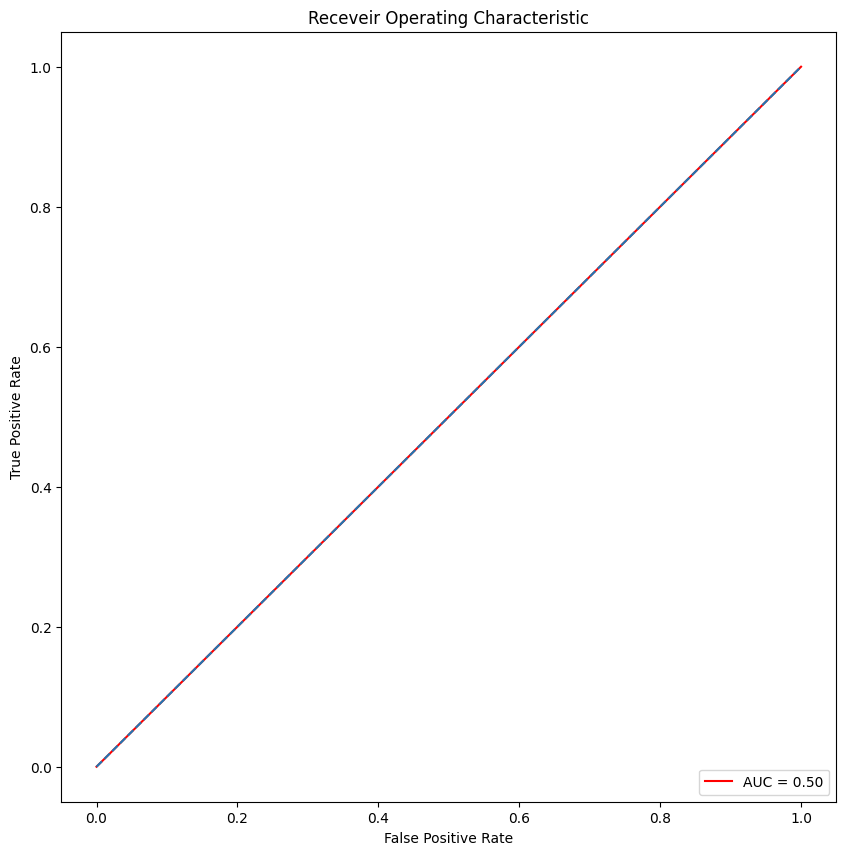

In [51]:
plt.figure(figsize=(10,10))
plt.title("Receveir Operating Characteristic")
plt.plot(false_positive_rate,true_positive_rate, color="red", label= "AUC = %0.2f" % roc_auc)
plt.legend(loc = "lower right")
plt.plot([0,1],[0,1], linestyle="--")
plt.axis("tight")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

## 2.2 Logistic regression

In [52]:
estimator = LogisticRegression(solver="liblinear")
estimator.fit(X_train, y_train)
#cv_results = cross_validate(estimator, X_train, y_train, cv=3,return_estimator=True)

LogisticRegression(solver='liblinear')

In [19]:
cv_results['test_score']

array([0.69822485, 0.73214286, 0.66071429])

In [20]:
cv_results['test_score'].mean()

0.6970273316427162

In [21]:
test_score = []
for i in range(len(cv_results['estimator'])):
  test_score.append(cv_results['estimator'][i].score(X_test, y_test))

In [22]:
sum(test_score) / len(test_score)

0.672514619883041

In [53]:
score(estimator)

score train : 0.7069 score test : 0.7193 


In [54]:
y_pred =estimator.predict(X_test)
#y_pred = cv_results['estimator'][2].predict(X_test)

In [55]:
confusion(y_test, y_pred)

,pred_0,pred_1
test_0,29,8
test_1,8,12


In [56]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.6918918918918919

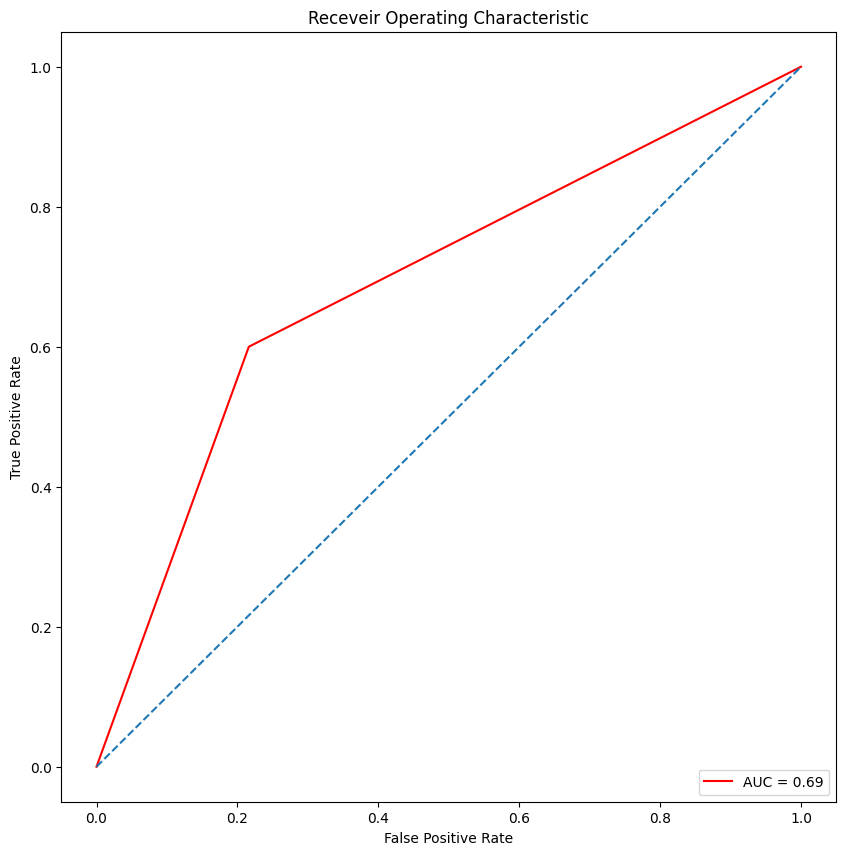

In [57]:
plt.figure(figsize=(10,10))
plt.title("Receveir Operating Characteristic")
plt.plot(false_positive_rate,true_positive_rate, color="red", label= "AUC = %0.2f" % roc_auc)
plt.legend(loc = "lower right")
plt.plot([0,1],[0,1], linestyle="--")
plt.axis("tight")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

# 2.3 SVM

In [72]:
estimator = LinearSVC(dual=False)
estimator.fit(X_train, y_train)
cv_results = cross_validate(estimator, X_train, y_train, cv=3,return_estimator=True)

In [73]:
cv_results['test_score']

array([0.68639053, 0.64880952, 0.75595238])

In [74]:
cv_results['test_score'].mean()

0.6970508124354278

In [75]:
test_score = []
for i in range(len(cv_results['estimator'])):
  test_score.append(cv_results['estimator'][i].score(X_test, y_test))

In [76]:
sum(test_score) / len(test_score)

0.7485380116959064

In [77]:
score(estimator)

score train : 0.7089 score test : 0.7544 


In [68]:
y_pred =estimator.predict(X_test)
#y_pred = cv_results['estimator'][2].predict(X_test)

In [69]:
confusion(y_test, y_pred)

,pred_0,pred_1
test_0,29,8
test_1,6,14


In [70]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7418918918918919

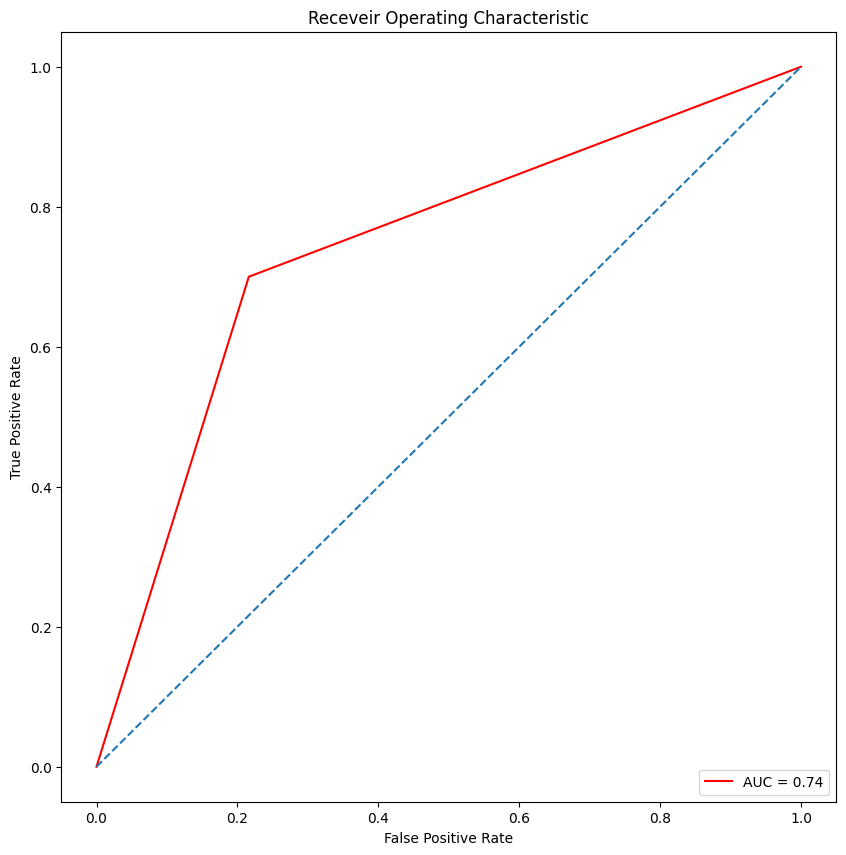

In [71]:
plt.figure(figsize=(10,10))
plt.title("Receveir Operating Characteristic")
plt.plot(false_positive_rate,true_positive_rate, color="red", label= "AUC = %0.2f" % roc_auc)
plt.legend(loc = "lower right")
plt.plot([0,1],[0,1], linestyle="--")
plt.axis("tight")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()